In [2]:
import numpy as np
from __future__ import division

%matplotlib inline
from matplotlib import pyplot as plt

from itertools import product

In [52]:
NUM_SITES = 3
N=10000
T=1000
L=[100000 for i in range(NUM_SITES-1)]
r=10**-8

In [70]:
R2_AB = []
R2_BC = []
R2_AC = []
A = []
B = []
C = []
#P = 1/(2**NUM_SITES) * np.ones(tuple(2 for i in range(NUM_SITES)))
P = np.array([[[0.25,0.1],           ###    ABC, ABc
             [0.05,0.1]],            ###    AbC, Abc
              [[0.1,0.05],           ###    aBC, aBc
              [0.1,0.25]]])          ###    abC, abc 

numr = 0
for t in range(T):
    ## sample/reproduce
    n = np.random.multinomial(N,P.flatten())

    ## generate chromosomes
    ## change '3' in the regex to NUM_SITES
    chroms = []
    for (k,j) in enumerate(n):
        P[tuple(int(i) for i in '{0:03b}'.format(k))] = 1/N * j
        for l in range(j):
            chroms.append('{0:03b}'.format(k))
    
    ## assort into pairs
    order = np.random.permutation(N)
    assert N % 2 == 0
    for m in range(int(N/2)):
        m = 2*m
        dip1 = order[m]
        dip2 = order[m+1]
            
        ## simulate recombinatione events
        ## crossover event simulation
        for (i,l) in enumerate(L):
            X = np.random.poisson(r*l)
            if X % 2 == 1:
                temp1 = chroms[dip1]
                temp2 = chroms[dip2]
                chroms[dip1] = temp1[0:(i+1)] + temp2[(i+1):]
                chroms[dip2] = temp2[0:(i+1)] + temp1[(i+1):]
        
    ## count chromosomes
    P = np.zeros(tuple(2 for i in range(NUM_SITES)))
    for chrom in chroms:
        P[tuple(int(char) for char in chrom)] += 1/N

    A.append(np.sum(P[0,:,:])) 
    B.append(np.sum(P[:,0,:])) 
    C.append(np.sum(P[:,:,0])) 
    
    AB = np.sum(P[0,0,:])
    BC = np.sum(P[:,0,0])
    AC = np.sum(P[0,:,0])
    
    R2_AB.append( (AB - A[-1]*B[-1]) / (A[-1]*(1-A[-1])*B[-1]*(1-B[-1])) )
    R2_BC.append( (BC - C[-1]*B[-1]) / (C[-1]*(1-C[-1])*B[-1]*(1-B[-1])) )
    R2_AC.append( (AC - A[-1]*C[-1]) / (A[-1]*(1-A[-1])*C[-1]*(1-C[-1])) )



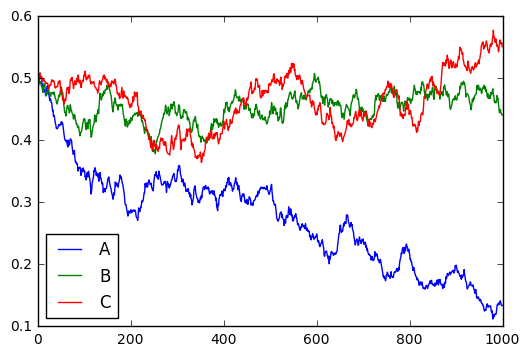

In [72]:
plt.plot(range(T),A,label='A')
plt.plot(range(T),B,label='B')
plt.plot(range(T),C,label='C')
plt.legend(loc=3)


In [ ]:
plt.plot(range(T),R,label='A')
plt.plot(range(T),B,label='B')
plt.plot(range(T),C,label='C')
plt.legend(loc=3)